In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

# Data preprocessing 
## Data preparation:
* Fix NA values
* Parse date-time into pandas dataframe index
* Specified clear names for each columns

In [2]:
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

In [3]:
temp = pd.read_csv('data_hrly.csv')

In [4]:
dataset = pd.read_csv('data_hrly.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset['month'] = np.array(temp['month'])
dataset = dataset[24:]
print("** DATA PROCESSING COMPLETED **")
dataset.to_csv('pollution.csv')

** DATA PROCESSING COMPLETED **


# Importing and visualizing the data


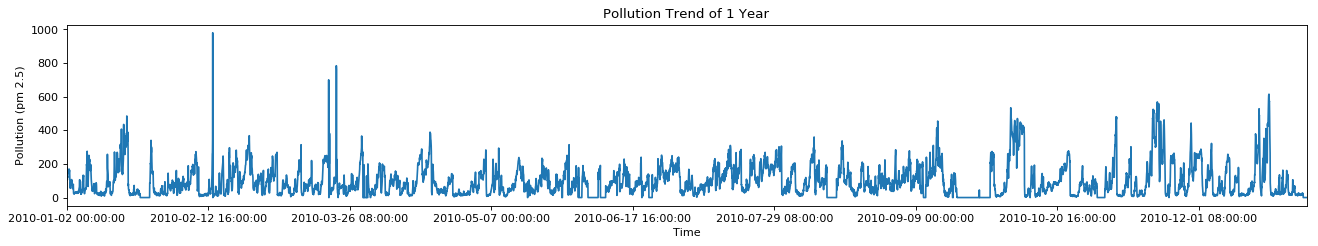

In [5]:
dataset = pd.read_csv('pollution.csv',index_col='date')
fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
dataset['pollution'][:365*24].plot()
plt.title('Pollution Trend of 1 Year')
plt.xlabel('Time')
plt.ylabel('Pollution (pm 2.5)')
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#Label Encoder
lbe = LabelEncoder()
#One hot encoder for the wind direction
ohe = OneHotEncoder(categorical_features=[4])
ohe_month = OneHotEncoder(categorical_features=[10])
pol_scaler = MinMaxScaler()
wea_scaler = MinMaxScaler()

In [7]:
dataset = pd.read_csv('pollution.csv',index_col='date')
dataset['wnd_dir'] = lbe.fit_transform(dataset['wnd_dir'])
dataset= pd.DataFrame(ohe.fit_transform(dataset).toarray()[:,1:])
dataset = ohe_month.fit_transform(dataset).toarray()
dataset = pd.DataFrame(dataset[:,1:])
pollution_data=np.array(dataset.iloc[:,14])
weather_data=np.array(dataset.drop(14,axis=1))
pollution_data =pol_scaler.fit_transform(pollution_data.reshape(-1,1))
#Creating the dataset for DNN
weather_data = wea_scaler.fit_transform(weather_data)
print("Shape: ",weather_data.shape)

Shape:  (43800, 20)


/usr/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/usr/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in vers

# Splitting the data into train and test set

In [8]:
#FOR RNN DATA
training_set_rnn = pollution_data[:40000,:]
training_set_dnn = weather_data[:40000,:]
test_set_rnn = pollution_data[40000:,:]
test_set_dnn = weather_data[40000:,:]

In [9]:
def next_batch(training_data_rnn,training_data_dnn,steps):
    """
    INPUT: Data(For RNN and DNN), Time Steps per batch
    OUTPUT: Input batch for RNN and DNN at 't' and Output data (pollution) at 't+1'
    """
    
    # Randomly initializing the start point
    ts_start = np.random.randint(low = 0, high = len(training_data_rnn)-(steps*25))
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch_rnn = training_data_rnn[ts_start: ts_start + (steps+1)*24 ].reshape(-1,steps+1,24)
    y_batch_dnn = training_data_dnn[ts_start: ts_start + (steps+1)*24 : 24]
    # Reshaping the output
    return y_batch_rnn[:,:-1,:] , y_batch_dnn[:-1,:],y_batch_rnn[:,1:,:]
    

In [10]:
import os
#Setting up tensorflow on GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from nn_function import *

In [11]:
#Reseting the default global graph
tf.reset_default_graph()

# Creating the neural network

In [12]:
#Declarying the constants
NUMBER_NEU = 128
N_IP = 24
N_OP = 24
STEPS = 60
LR = 0.00001
#For 40k iterations
ITER = 100000
#Output neurons for the LSTM and DNN layers
N_OUT =128

In [13]:
#Placeholders for input batches
x_rnn = tf.placeholder(dtype=tf.float32,shape=(None,None,N_IP))
x_dnn = tf.placeholder(dtype=tf.float32,shape=(None,20))
#Placeholders for output batches
y= tf.placeholder(dtype=tf.float32,shape=(None,N_OP))
#For dropout layers
hold_proba = tf.placeholder(dtype=tf.float32)

In [14]:
#Making the LSTM cell
cell = dropout_wrapper(hold_proba,create_LSTM_cell(NUMBER_NEU))

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [15]:
#RNN output
output , states = create_RNN(cell,x_rnn)
#Selecting the final output form the layer
rnn_output = output[-1]
#Connecting the output to a DNN layer
lstm_fc_out = dnn_layer(rnn_output,N_OUT,name="LSTM_op")
lstm_fc_drop = tf.nn.dropout(lstm_fc_out, hold_proba,name="drop0")

In [16]:
#Making the dnn layers with the DNN data
dnn_op = dnn_layer(x_dnn,N_OUT)

In [17]:
#Connecting/Concatenating the DNN and RNN layers
connected_layer = tf.concat([dnn_op, lstm_fc_drop], axis=1,name="connected")
dropout_layer = tf.nn.dropout(connected_layer,hold_proba,name="drop1")
#Adding another DNN+dropout layer with relu activation
connected_layer2 = tf.nn.relu(dnn_layer(dropout_layer,size=1024),name="dnn1")
dropout_layer2 = tf.nn.dropout(connected_layer2,hold_proba,name="drop2")

In [18]:
#Calculating the final output node with Sigmoid activation
network_op = tf.sigmoid(dnn_layer(dropout_layer2,24),name="network_op")


In [19]:
#Creating the MAE loss function
loss = tf.losses.huber_loss(labels=network_op,predictions=y)
#Creating the optimizer and trainer
optim = tf.train.AdamOptimizer(learning_rate=LR)
train = optim.minimize(loss)


In [20]:
#Creating the varaible initializer and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(ITER):
        x_rnn_batch,x_dnn_batch,y_batch = next_batch(training_set_rnn,training_set_dnn,steps=STEPS)
        sess.run(train,feed_dict = {x_rnn:x_rnn_batch,x_dnn:x_dnn_batch ,y: y_batch.reshape(-1,24) , hold_proba:0.5})
        if i % 100 == 0:
            x_rnn_test,x_dnn_test,y_test = next_batch(test_set_rnn,test_set_dnn,steps=30)
            print("At step",i,"\t\thuber_loss (Train): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_rnn_batch,x_dnn:x_dnn_batch ,y: y_batch.reshape(-1,24) , hold_proba:1.0})),"\t\thuber_loss (Test): %1.5f"%(sess.run(loss,feed_dict = {x_rnn:x_rnn_test,x_dnn:x_dnn_test ,y: y_test.reshape(-1,24) , hold_proba:1.0})))
    saver.save(sess, "Pollution_model/model")

# Visualizing and testing the model 

In [21]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [80]:
with tf.Session() as sess:
    #Restoring the model
    saver.restore(sess, "Pollution_model/model")
    #Preparing batches
    x_rnn_batch,x_dnn_batch,y_batch = next_batch(test_set_rnn,test_set_dnn,steps=100)
    #Predicting the output
    output = sess.run(network_op, feed_dict={x_rnn:x_rnn_batch,x_dnn:x_dnn_batch, hold_proba:1.0})

INFO:tensorflow:Restoring parameters from Pollution_model/model


In [109]:
#Inverse scaling the predicted and actual values
y_inversed = pol_scaler.inverse_transform(y_batch.reshape(100,24)[:,:-1])
pred_inversed = pol_scaler.inverse_transform(output[:,1:])
dataframe = np.append(np.array([x.max() for x in y_inversed]).reshape(-1,1),np.array([y.max() for y in pred_inversed]).reshape(-1,1),1)

In [10]:
## Creating the dataframe
df = pd.DataFrame(dataframe,columns=['Actual','Prediction'])
#Plotting the graph
df[:100:10].plot.bar()
plt.title("Actual Data vs Prediction Data (100 days of Test Dataset)")
plt.ylabel("pm 2.5")
plt.xlabel('Timestep')
plt.show()
#Calculating MAE and RMSE error
y_true = df['Actual'].values
y_pred = df['Prediction'].values
score_mae = mean_absolute_error(y_true,y_pred)
print("Mean Absolute Error (Test)\t=\t%1.2f"%(score_mae))
print("Error ratio (Test)\t\t=\t%1.2f"%((score_mae/df['Actual'].max())*100),"%")

NameError: name 'dataframe' is not defined

In [33]:
#Converting dataset to spreadsheet
df.to_csv('prediction_24hrModel.csv')

# Predicting Future data

In [76]:
forecast = 6

In [77]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    # Restoring the model
    saver.restore(sess, "Pollution_model/model")

    #Creating the Seed of 1 Week's data
    train_seed_rnn = list(training_set_rnn[-24*forecast:].reshape(-1,forecast,24))
    train_seed_dnn = list(training_set_dnn[-24*forecast::24])
    #Predicting the next week's data
    for iteration in range(6):
        rnn_batch = np.array(train_seed_rnn[0][-forecast:])
        rnn_batch = rnn_batch.reshape(-1,forecast,24)
        dnn_batch = np.array(train_seed_dnn)[-forecast:]
        y_pred = sess.run(network_op, feed_dict={x_rnn:rnn_batch,x_dnn:dnn_batch, hold_proba:1.0})
        #print("\nPrediction: ",y_pred[0, -1])
        train_seed_rnn[0] = np.vstack([train_seed_rnn[0], y_pred[-1]])
        #print("Feed_data: ",test_set_dnn[test_ind])
        train_seed_dnn.append(train_seed_dnn[-1])

        

INFO:tensorflow:Restoring parameters from Pollution_model/model


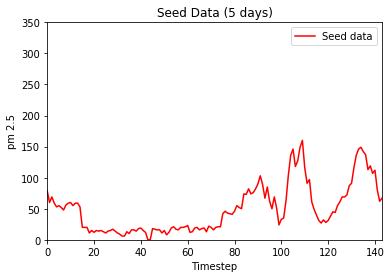

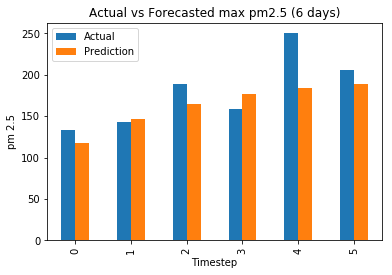



**Statistics**

Actual Max:	 250.0
Predicted Max:	 188.515002251

Mean Absolute Error:	 23.9181394627
Error ratio (Test):	9.57 %


In [104]:
#Inverse scaling the value
seed_data = pol_scaler.inverse_transform(training_set_rnn[-24*forecast:])
prediction = pol_scaler.inverse_transform(np.array(train_seed_rnn[0][-6:]))
prediction_data = []
for x in prediction:
    prediction_data.append(x.max())
    
actual =  pol_scaler.inverse_transform(test_set_rnn[:24*6]).reshape(-1,24)
actual_data = []
for x in actual:
    actual_data.append(x.max())

#Creating the dataframe
dataframe = np.append(np.array(actual_data).reshape(-1,1),np.array(prediction_data).reshape(-1,1),1)
df = pd.DataFrame(dataframe,columns=['Actual','Prediction'])

#Displaying the seed data
pd.DataFrame(list(seed_data),columns=['Seed data']).plot(c='Red')
plt.ylim((0,350))
plt.title("Seed Data (5 days)")
plt.ylabel("pm 2.5")
plt.xlabel('Timestep')
plt.show()

#Plotting the bar chart for forecast
df.plot.bar()
plt.title("Actual vs Forecasted max pm2.5 (6 days)")
plt.ylabel("pm 2.5")
plt.xlabel('Timestep')
plt.show()


print("\n\n**Statistics**")
print("\nActual Max:\t",df['Actual'].max())
print("Predicted Max:\t",df['Prediction'].max())
y_true = df['Actual'].values
y_pred = df['Prediction'].values
score_mae = mean_absolute_error(y_true,y_pred)
print("\nMean Absolute Error:\t",score_mae)
print("Error ratio (Test):\t%1.2f"%((score_mae/df['Actual'].max())*100),"%")